In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/datasetfire.zip -d /content/

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [ ]:
DIRECTORY = r"/content/fire_dataset"
CATEGORIES = ["fire_images", "non_fire_images"]


print("[INFO] loaded images...")

data = []
labels = []

[INFO] loaded images...


/content/fire_dataset/fire_images
/content/fire_dataset/non_fire_images
9420800/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
24/24 [==============================] - 22s 414ms/step - loss: 0.5352 - accuracy: 0.7523 - val_loss: 0.3362 - val_accuracy: 0.8350
Epoch 2/20
24/24 [==============================] - 8s 345ms/step - loss: 0.3071 - accuracy: 0.8801 - val_loss: 0.2307 - val_accuracy: 0.9600
Epoch 3/20
24/24 [==============================] - 8s 344ms/step - loss: 0.2099 - accuracy: 0.9426 - val_loss: 0.1784 - val_accuracy: 0.9700
Epoch 4/20
24/24 [==============================] - 8s 343ms/step - loss: 0.1747 - accuracy: 0.9505 - val_loss: 0.1474 - val_accuracy: 0.9700
Epoch 5/20
24/24 [==============================] - 8s 345ms/step - loss: 0.1466 - accuracy: 0.9570 - val_loss: 0.1273 - val_accuracy: 0.9700
Epoch 6/20
24/24 [==============================] - 8s 341ms/step - loss: 0.1385 - accuracy: 0.9648 - val_loss: 0.1122 - val_accuracy: 0.9700
Epoch 7/20
24/24 [==============================] - 8s 341ms/step - loss: 0.1070 - accuracy: 0.9648 - val_loss: 0.0983 - val_accuracy: 0.9750
Epoch

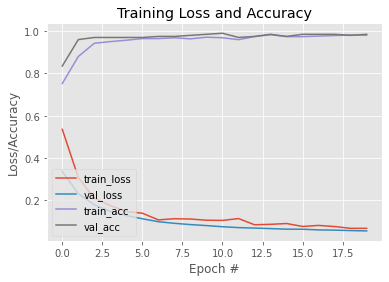

In [ ]:
from math import e
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    print(path)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
	layer.trainable = False


print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
(fire, nonefire) = predIdxs[0]
if(fire > nonefire):
		print('fire')
else:
		print('without_fire')
print("Predict: ", predIdxs)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


print("[INFO] saving mask detector model...")
model.save("fire_detector.model", save_format="h5")


N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

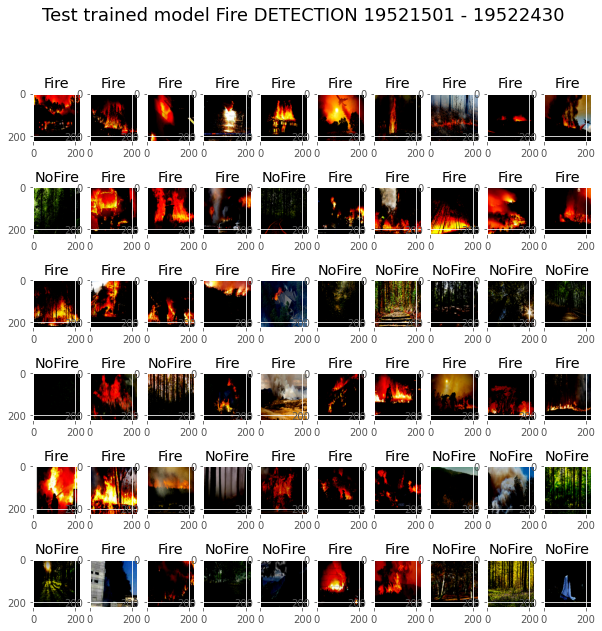

In [ ]:
predIdxs = model.predict(testX, batch_size=BS)
fig, axs = plt.subplots(nrows=6, ncols=10, figsize=(10, 10))
axs = axs.flatten()
for i in range(60):
	axs[i].imshow(testX[100+i])
	(fire, nonefire) = predIdxs[100 + i]
	if fire > nonefire:
		titlee = 'Fire'
	else:
		titlee = 'NoFire'
	axs[i].set(title=titlee)
fig.suptitle('Test trained model Fire DETECTION', fontsize=18)
plt.savefig('result_test.png')